这里显示 使用神经网络 对数字识别进行预测

In [1]:
import numpy as np
from scipy import io as spio
from matplotlib import pyplot as plt
from scipy import optimize
from matplotlib.font_manager import FontProperties
import time
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)    # 解决windows环境下画图汉字乱码问题
%matplotlib inline

In [2]:
# 显示100个数字
def display_data(imgData):
    sum = 0
    '''
    显示100个数（若是一个一个绘制将会非常慢，可以将要画的数字整理好，放到一个矩阵中，显示这个矩阵即可）
    - 初始化一个二维数组
    - 将每行的数据调整成图像的矩阵，放进二维数组
    - 显示即可
    '''
    m,n = imgData.shape
    width = np.int32(np.round(np.sqrt(n)))
    height = np.int32(n/width)
    rows_count = np.int32(np.floor(np.sqrt(m)))
    cols_count = np.int32(np.ceil(m/rows_count))
    pad = 1
    display_array = -np.ones((pad+rows_count*(height+pad),pad+cols_count*(width+pad)))
    for i in range(rows_count):
        for j in range(cols_count):
            if sum >= m: # 超过了行数，退出当前循环
                break
            display_array[pad+i*(height+pad):pad+i*(height+pad)+height,pad+j*(width+pad):pad+j*(width+pad)+width] = imgData[sum,:].reshape(height,width,order="F")    # order=F指定以列优先，在matlab中是这样的，python中需要指定，默认以行
            sum += 1
        if sum >= m:  # 超过了行数，退出当前循环
            break
            
    plt.imshow(display_array,cmap='gray')   # 显示灰度图像
    plt.axis('off')
    plt.show()

In [3]:
# 代价函数
def nnCostFunction(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda):
    length = nn_params.shape[0] # theta的中长度
    # 还原theta1和theta2
    Theta1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):length].reshape(num_labels,hidden_layer_size+1)
    
    # np.savetxt("Theta1.csv",Theta1,delimiter=',')
    
    m = X.shape[0]
    class_y = np.zeros((m,num_labels))      # 数据的y对应0-9，需要映射为0/1的关系
    # 映射y
    for i in range(num_labels):
        class_y[:,i] = np.int32(y==i).reshape(1,-1) # 注意reshape(1,-1)才可以赋值
     
    '''去掉theta1和theta2的第一列，因为正则化时从1开始'''    
    Theta1_colCount = Theta1.shape[1]    
    Theta1_x = Theta1[:,1:Theta1_colCount]
    Theta2_colCount = Theta2.shape[1]    
    Theta2_x = Theta2[:,1:Theta2_colCount]
    # 正则化向theta^2
    term = np.dot(np.transpose(np.vstack((Theta1_x.reshape(-1,1),Theta2_x.reshape(-1,1)))),np.vstack((Theta1_x.reshape(-1,1),Theta2_x.reshape(-1,1))))
    
    '''正向传播,每次需要补上一列1的偏置bias'''
    a1 = np.hstack((np.ones((m,1)),X))      
    z2 = np.dot(a1,np.transpose(Theta1))    
    a2 = sigmoid(z2)
    a2 = np.hstack((np.ones((m,1)),a2))
    z3 = np.dot(a2,np.transpose(Theta2))
    h = sigmoid(z3)
    '''代价'''    
    J = -(np.dot(np.transpose(class_y.reshape(-1,1)),np.log(h.reshape(-1,1)))+np.dot(np.transpose(1-class_y.reshape(-1,1)),np.log(1-h.reshape(-1,1)))-Lambda*term/2)/m   
    
    return np.ravel(J)

# 梯度
def nnGradient(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,Lambda):
    length = nn_params.shape[0]
    Theta1 = nn_params[0:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):length].reshape(num_labels,hidden_layer_size+1)
    m = X.shape[0]
    class_y = np.zeros((m,num_labels))      # 数据的y对应0-9，需要映射为0/1的关系    
    # 映射y
    for i in range(num_labels):
        class_y[:,i] = np.int32(y==i).reshape(1,-1) # 注意reshape(1,-1)才可以赋值
     
    '''去掉theta1和theta2的第一列，因为正则化时从1开始'''
    Theta1_colCount = Theta1.shape[1]    
    Theta1_x = Theta1[:,1:Theta1_colCount]
    Theta2_colCount = Theta2.shape[1]    
    Theta2_x = Theta2[:,1:Theta2_colCount]
    
    Theta1_grad = np.zeros((Theta1.shape))  #第一层到第二层的权重
    Theta2_grad = np.zeros((Theta2.shape))  #第二层到第三层的权重
    
    Theta1[:,0] = 0
    Theta2[:,0] = 0
    '''正向传播，每次需要补上一列1的偏置bias'''
    a1 = np.hstack((np.ones((m,1)),X))
    z2 = np.dot(a1,np.transpose(Theta1))
    a2 = sigmoid(z2)
    a2 = np.hstack((np.ones((m,1)),a2))
    z3 = np.dot(a2,np.transpose(Theta2))
    h = sigmoid(z3)
    
    '''反向传播，delta为误差，'''
    delta3 = np.zeros((m,num_labels))
    delta2 = np.zeros((m,hidden_layer_size))
    for i in range(m):
        delta3[i,:] = h[i,:]-class_y[i,:]
        Theta2_grad = Theta2_grad+np.dot(np.transpose(delta3[i,:].reshape(1,-1)),a2[i,:].reshape(1,-1))
        delta2[i,:] = np.dot(delta3[i,:].reshape(1,-1),Theta2_x)*sigmoidGradient(z2[i,:])
        Theta1_grad = Theta1_grad+np.dot(np.transpose(delta2[i,:].reshape(1,-1)),a1[i,:].reshape(1,-1))
    
    '''梯度'''
    grad = (np.vstack((Theta1_grad.reshape(-1,1),Theta2_grad.reshape(-1,1)))+Lambda*np.vstack((Theta1.reshape(-1,1),Theta2.reshape(-1,1))))/m
    return np.ravel(grad)

In [4]:
# S型函数    
def sigmoid(Z):
    A = 1.0/(1.0+np.exp(-Z))
    return A

# S型函数导数
def sigmoidGradient(z):
    g = sigmoid(z)*(1-sigmoid(z))
    return g

# 随机初始化权重theta
def randInitializeWeights(L_in,L_out):
    W = np.zeros((L_out,1+L_in))    # 对应theta的权重
    epsilon_init = (6.0/(L_out+L_in))**0.5
    W = np.random.rand(L_out,1+L_in)*2*epsilon_init-epsilon_init # np.random.rand(L_out,1+L_in)产生L_out*(1+L_in)大小的随机矩阵
    return W


# 检验梯度是否计算正确
def checkGradient(Lambda = 0):
    '''构造一个小型的神经网络验证，因为数值法计算梯度很浪费时间，而且验证正确后之后就不再需要验证了'''
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    initial_Theta1 = debugInitializeWeights(input_layer_size,hidden_layer_size)
    initial_Theta2 = debugInitializeWeights(hidden_layer_size,num_labels)
    X = debugInitializeWeights(input_layer_size-1,m)
    y = 1+np.transpose(np.mod(np.arange(1,m+1), num_labels))  # 初始化y
    
    y = y.reshape(-1,1)
    nn_params = np.vstack((initial_Theta1.reshape(-1,1),initial_Theta2.reshape(-1,1)))  #展开theta 
    '''BP求出梯度'''
    grad = nnGradient(nn_params, input_layer_size, hidden_layer_size, 
                     num_labels, X, y, Lambda)  
    '''使用数值法计算梯度'''
    num_grad = np.zeros((nn_params.shape[0]))
    step = np.zeros((nn_params.shape[0]))
    e = 1e-4
    for i in range(nn_params.shape[0]):
        step[i] = e
        loss1 = nnCostFunction(nn_params-step.reshape(-1,1), input_layer_size, hidden_layer_size, 
                              num_labels, X, y, 
                              Lambda)
        loss2 = nnCostFunction(nn_params+step.reshape(-1,1), input_layer_size, hidden_layer_size, 
                              num_labels, X, y, 
                              Lambda)
        num_grad[i] = (loss2-loss1)/(2*e)
        step[i]=0
    # 显示两列比较
    res = np.hstack((num_grad.reshape(-1,1),grad.reshape(-1,1)))
    print(res)

# 初始化调试的theta权重
def debugInitializeWeights(fan_in,fan_out):
    W = np.zeros((fan_out,fan_in+1))
    x = np.arange(1,fan_out*(fan_in+1)+1)
    W = np.sin(x).reshape(W.shape)/10
    return W

In [5]:
# 预测
def predict(Theta1,Theta2,X):
    m = X.shape[0]
    #num_labels = Theta2.shape[0]
    #p = np.zeros((m,1))
    '''正向传播，预测结果'''
    X = np.hstack((np.ones((m,1)),X))
    h1 = sigmoid(np.dot(X,np.transpose(Theta1)))
    h1 = np.hstack((np.ones((m,1)),h1))
    h2 = sigmoid(np.dot(h1,np.transpose(Theta2)))
    
    '''
    返回h中每一行最大值所在的列号
    - np.max(h, axis=1)返回h中每一行的最大值（是某个数字的最大概率）
    - 最后where找到的最大概率所在的列号（列号即是对应的数字）
    '''
    #np.savetxt("h2.csv",h2,delimiter=',')
    p = np.array(np.where(h2[0,:] == np.max(h2, axis=1)[0]))  
    for i in np.arange(1, m):
        t = np.array(np.where(h2[i,:] == np.max(h2, axis=1)[i]))
        p = np.vstack((p,t))
    return p    


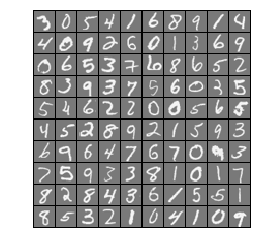

         Current function value: 1.059037
         Iterations: 18
         Function evaluations: 182
         Gradient evaluations: 170
(u'\u6267\u884c\u65f6\u95f4\uff1a', 50.123000144958496)
[-0.42109302 -0.03209883 -0.0867308  ..., -0.4111507   1.69801146
  0.23224257]


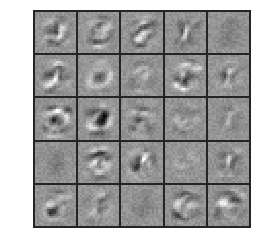

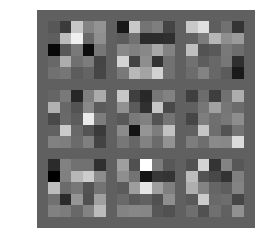

预测准确度为：87.140000%


In [6]:
def neuralNetwork(input_layer_size,hidden_layer_size,out_put_layer):
    data_img = spio.loadmat("../data/3-neural_network/data_digits.mat")
    X = data_img['X']
    y = data_img['y']
    m,n = X.shape

    ##　随机显示几行数据
    rand_indices = [t for t in [np.random.randint(x-x, m) for x in range(100)]]  # 生成100个0-m的随机数
    display_data(X[rand_indices,:])     # 显示100个数字    
    
    #nn_params = np.vstack((Theta1.reshape(-1,1),Theta2.reshape(-1,1)))
    Lambda = 1
    
    initial_Theta1 = randInitializeWeights(input_layer_size,hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size,out_put_layer)
    
    initial_nn_params = np.vstack((initial_Theta1.reshape(-1,1),initial_Theta2.reshape(-1,1)))  # 展开theta
    #np.savetxt("testTheta.csv",initial_nn_params,delimiter=",")
    start = time.time()
    result = optimize.fmin_cg(nnCostFunction, initial_nn_params, fprime=nnGradient, args=(input_layer_size,hidden_layer_size,out_put_layer,X,y,Lambda))
    print (u'执行时间：',time.time()-start)
    print (result)
    '''可视化 Theta1'''
    length = result.shape[0]
    Theta1 = result[0:hidden_layer_size*(input_layer_size+1)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = result[hidden_layer_size*(input_layer_size+1):length].reshape(out_put_layer,hidden_layer_size+1)    
    display_data(Theta1[:,1:length])
    display_data(Theta2[:,1:length])
    '''预测'''
    p = predict(Theta1,Theta2,X)
    print (u"预测准确度为：%f%%" % np.mean((p == y.reshape(-1,1))*100))
    res = np.hstack((p,y.reshape(-1,1)))
    np.savetxt("predict.csv", res, delimiter=',')

neuralNetwork(400, 25, 10)